# Temporary Jupyter Notebook for SCRIPT 4

## Rachel's Part:

In [2]:
import numpy as np
import pandas as pd
import altair as alt

In [3]:
from hashlib import sha1

import matplotlib.pyplot as plt
from IPython.display import HTML

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    normalize,
    scale,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)

from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

In [4]:
# set max column and max row display of dataframes
pd.set_option("display.max_colwidth", 200)
pd.set_option('display.max_rows', 50)

### Import processed data (not sure how to do this...)

We can delete the next cell after downloading processed data:

In [5]:
# Packages necessary for importing data (from a zip file containing 2 dataset CSVs)
import requests, zipfile
from urllib.request import urlopen
from io import BytesIO

zip_file_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
zip_file_load = urlopen(zip_file_url)
zipinmemory = BytesIO(zip_file_load.read())
zip_file = zipfile.ZipFile(zipinmemory)

# Only load the first file in the zip folder
diabetes_csv = pd.read_csv(zip_file.open(zip_file.namelist()[0]))

# Change `readmitted` target column to binary "YES" or "NO" values if admitted or not.
pattern = r'[<>]30'
diabetes_csv["readmitted"] = diabetes_csv["readmitted"].str.replace(pattern,"YES",regex = True)

# Convert any ? to na
diabetes_csv = diabetes_csv.replace("?", np.NaN)

# Drop any rows with na
diabetes_clean = diabetes_csv.dropna()

# Drop columns not useful to answering our question
diabetes_clean = diabetes_csv.drop(columns = ["encounter_id", "patient_nbr", "race", "weight", "payer_code", "medical_specialty", "examide", "citoglipton"])

diabetes_clean.head(10)

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Female,[0-10),6,25,1,1,41,0,1,0,...,No,No,No,No,No,No,No,No,No,NO
1,Female,[10-20),1,1,7,3,59,0,18,0,...,No,Up,No,No,No,No,No,Ch,Yes,YES
2,Female,[20-30),1,1,7,2,11,5,13,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,Male,[30-40),1,1,7,2,44,1,16,0,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Male,[40-50),1,1,7,1,51,0,8,0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,Male,[50-60),2,1,2,3,31,6,16,0,...,No,Steady,No,No,No,No,No,No,Yes,YES
6,Male,[60-70),3,1,2,4,70,1,21,0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,Male,[70-80),1,1,7,5,73,0,12,0,...,No,No,No,No,No,No,No,No,Yes,YES
8,Female,[80-90),2,1,4,13,68,2,28,0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,Female,[90-100),3,3,4,12,33,3,18,0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Split Data into Training and Testing

In [6]:
# Take a random and representative sample of our diabetes dataset to apply data analysis to

diabetes_subset = diabetes_clean.sample(n = 1_000)
diabetes_subset

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
53404,Female,[70-80),2,1,7,7,67,4,26,0,...,No,Down,No,No,No,No,No,Ch,Yes,NO
78102,Female,[40-50),2,2,7,5,47,1,19,0,...,No,Down,No,No,No,No,No,Ch,Yes,YES
86953,Female,[70-80),1,6,7,5,52,0,18,4,...,No,Steady,No,No,No,No,No,No,Yes,YES
36951,Male,[80-90),1,3,7,10,37,1,19,0,...,No,No,No,No,No,No,No,No,No,NO
42366,Female,[40-50),2,1,7,4,1,0,9,0,...,No,No,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27336,Female,[70-80),2,1,2,7,50,6,26,0,...,No,No,No,No,No,No,No,No,Yes,NO
66720,Female,[70-80),3,6,1,6,58,3,30,0,...,No,Up,No,No,No,No,No,Ch,Yes,NO
53,Female,[50-60),1,1,7,1,53,0,11,1,...,No,Down,No,No,No,No,No,Ch,Yes,YES
11223,Female,[30-40),3,18,4,13,44,0,11,0,...,No,Steady,No,No,No,No,No,No,Yes,NO


In [7]:
# Change positive and negative labels of readmitted target column to 0 (not readmitted) and 1 (readmitted)

from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(diabetes_subset['readmitted'], classes=['NO','YES'])
encoded_labels = np.ravel(encoded_column_vector)

diabetes_subset["readmitted"] = encoded_labels

In [8]:
# Split the data into training (0.8) and testing (0.2)
train_df, test_df = train_test_split(diabetes_subset, test_size=0.2, random_state=123)

# Split the data into X and Y
X_train, y_train = train_df.drop(columns=["readmitted"]), train_df["readmitted"] 
X_test, y_test = test_df.drop(columns=["readmitted"]), test_df["readmitted"]

### Label features

In [9]:
# categorical features - OneHotEncoding
# numeric features - StandardScaler
# ordinal features - OrdinalEncoding
categorical_features = ["age", "diag_1", "diag_2", "diag_3", "max_glu_serum", "A1Cresult", "metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]
numeric_features = ["admission_type_id", "discharge_disposition_id", "admission_source_id", "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses" ]
ordinal_features = ["gender", "change", "diabetesMed"]
target_feature = "readmitted"

### Create transformers and preprocesser pipeline

In [10]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")), 
            ("scaler", StandardScaler()),
    ]
)

ordinal_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("ordinal", OrdinalEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features)
    ],
    #remainder = "passthrough"
)

In [11]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['admission_type_id',
                                  'discharge_disposition_id',
                                  'admission_source_id', 'time_in_hospital',
                                  'num_lab_procedures', 'num_procedures',
                                  'num_medications', 'number_outpatient',
                                  'number_emergency', 'number_inpatient',
                                  'number_diagnoses...
                                  'tolbutamide', 'pioglitazone',
                                  'rosiglitazone', 'acarbose', 'miglitol',
                                  'troglitazone', 'tolazamide',
                                  'glyburide-metformin', '

### Create model pipelines and test out different models (RBF SVM and LR) against DummyClassifier baseline

In [12]:
# Create an empty dictionary to store results
results_dict = {}

In [13]:
# Code adapted from MDS 571 - Lab 4
def store_results(classifier_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    # test cases for store_results function
    assert type(classifier_name) == str # test that the classifier_name is a string
    assert type(scores) == dict # test that the scores is a dictionary
    
    results_dict[classifier_name] = {
        "fit_time": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "score_time": "{:0.4f}".format(np.mean(scores["score_time"])),
        "test_accuracy": "{:0.4f}".format(np.mean(scores["test_accuracy"])),
        "train_accuracy": "{:0.4f}".format(np.mean(scores["train_accuracy"])),
        "test_f1": "{:0.4f}".format(np.mean(scores["test_f1"])),
        "train_f1": "{:0.4f}".format(np.mean(scores["train_f1"])),
        "test_recall": "{:0.4f}".format(np.mean(scores["test_recall"])),
        "train_recall": "{:0.4f}".format(np.mean(scores["train_recall"])),
        "test_precision": "{:0.4f}".format(np.mean(scores["test_precision"])),
        "train_precision": "{:0.4f}".format(np.mean(scores["train_precision"])),
        "test_average_precision": "{:0.4f}".format(np.mean(scores["test_precision"])),
        "train_average_precision": "{:0.4f}".format(np.mean(scores["train_precision"])),
        "test_roc_auc": "{:0.4f}".format(np.mean(scores["test_roc_auc"])),
        "train_roc_auc": "{:0.4f}".format(np.mean(scores["train_roc_auc"])),
    }

In [14]:
# Test 3 models against baseline DummyClassifier
classifiers = {
    "Dummy Classifier" : DummyClassifier(strategy = "stratified"),
    "RBF SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter = 1000),
    "Logistic Regression (balanced)": LogisticRegression(class_weight="balanced", max_iter = 1000),
}

In [15]:
# ignore warnings, DummyClassifier will output many 0s for scores but this is correct
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

scoring = ["accuracy", "f1", "recall", "precision", "average_precision", "roc_auc"]

for classifier_name, classifier in classifiers.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
    scores = cross_validate(pipe, X_train, y_train, return_train_score=True, scoring = scoring)
    store_results(classifier_name, scores, results_dict)

results_dict = pd.DataFrame(results_dict).T

results_dict

,Dummy Classifier,RBF SVM,Logistic Regression,Logistic Regression (balanced)
fit_time,0.0259,0.0654,0.0871,0.0745
score_time,0.0280,0.0411,0.0231,0.0223
test_accuracy,0.5100,0.6375,0.5862,0.5725
train_accuracy,0.5156,0.7356,0.8284,0.8319
test_f1,0.4569,0.4758,0.5009,0.5181
train_f1,0.4582,0.6287,0.8010,0.8163
test_recall,0.4583,0.3667,0.4611,0.5111
train_recall,0.4556,0.4979,0.7674,0.8299
test_precision,0.4560,0.6838,0.5522,0.5285
train_precision,0.4615,0.8539,0.8379,0.8032


According to the results it looks like Logistic Regression (balanced) had the highest training accuracy and f1 scores. RBF SVM is also extremely slow.

### Continuing work with Logistic Regression (balanced) pipeline

In [16]:
lr_bal_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("lr", LogisticRegression(class_weight="balanced"))])

### Hyperparameter Optimization with Logistic Regression (balanced)

In [33]:
scoring=["accuracy", "precision", "f1", "recall", 'roc_auc', 'average_precision']

pipe = make_pipeline(preprocessor, LogisticRegression(class_weight="balanced", max_iter = 1000))

param_grid = {
             "logisticregression__C": [10,100,500],
              }


random_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_jobs=-1, n_iter=2, cv=5, scoring= "f1")


In [34]:
random_search.fit(X_train, y_train)
random_search.best_params_

{'logisticregression__C': 10}

### Hyperparameter Optimization results (confusion matrix, precision-recall curve, AUC curve)

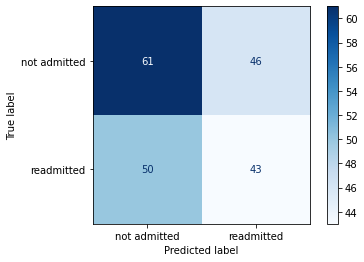

In [75]:
from sklearn.metrics import plot_confusion_matrix

cm = plot_confusion_matrix(random_search.best_estimator_, X_test, y_test, display_labels=["not admitted", "readmitted"], values_format="d", cmap=plt.cm.Blues)
cm

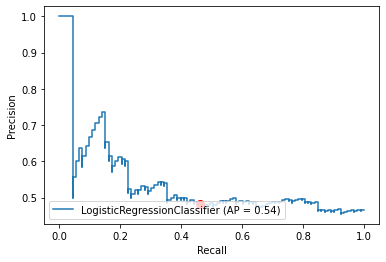

In [73]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(random_search, X_test, y_test, name='LogisticRegressionClassifier');
plt.plot(recall_score(y_test, random_search.predict(X_test)), precision_score(y_test, random_search.predict(X_test)), 'or', markersize=8)

In [65]:
print(classification_report(y_test, random_search.predict(X_test),
        target_names=["not admitted", "readmitted"]))

              precision    recall  f1-score   support

not admitted       0.55      0.54      0.55       107
  readmitted       0.48      0.49      0.49        93

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200



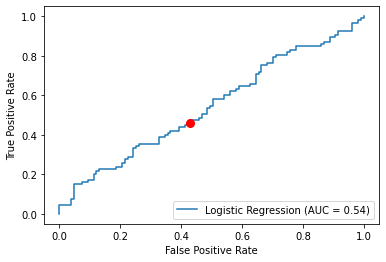

In [84]:
from sklearn.metrics import plot_roc_curve

cm = confusion_matrix(y_test, random_search.predict(X_test))

rc = plot_roc_curve(random_search, X_test, y_test, name='Logistic Regression');
plt.plot(cm[0,1]/(cm[0].sum()), cm[1,1]/(cm[1].sum()), 'or', markersize=8);


In [ ]:
As AUC means perfect classification, here we are getting AUC = 0.59 which is not close to 1 shows the model is not
predicting the classes accurately for most of the data.

### Use Logistic Regression (balanced) model and best hyperparameters on test set

In [66]:
random_search.best_estimator_.fit(X_train, y_train)
random_search.best_estimator_.score(X_test,y_test)

0.52

### Top Coefficients of Best Indicator Features

### EXTRA: Find Test Set With Most Predictive Readmission Outcome vs. No Readmission Outcome